# ArviZ migration guide

We have been working on refactoring ArviZ to allow more flexibility and extensibility of its elements
while keeping as much as possible a friendly user-interface that gives sensible results with little to no arguments.

One important change is enhanced modularity. Everything will still be available through a common namespace `arviz`,
but ArviZ will now be composed of 3 smaller libraries:

* [arviz-base](https://arviz-base.readthedocs.io/en/latest/) data related functionality, including converters from different PPLs.
* [arviz-stats](https://arviz-stats.readthedocs.io/en/latest/) for statistical functions and diagnostics.
* [arviz-plots](https://arviz-plots.readthedocs.io/en/latest/) for visual checks built on top of arviz-stats and arviz-base.

Each library depends only on a minimal set of libraries, with a lot of functionality built on top of optional dependencies.
This keeps ArviZ smaller and easier to install as you can install only the components you really need. The main examples are:

* `arviz-base` has no I/O library as a dependency, but you can use `netcdf4`, `h5netcdf` or `zarr` to read and write your data, allowing you to install only the one you need.
* `arviz-plots` has no plotting library as a dependency, but it can generate plots with `matplotlib`, `bokeh` or `plotly` if they are installed.

At the time of writing, `arviz-xyz` libraries are independent of the `arviz` library, but `arviz` tries to import the `arviz-xyz` libraries
and exposes all their elements through the `arviz.preview` namespace. In the future, with the ArviZ 1.0 release, the `arviz` namespace will look
like `arviz.preview` looks like today.

We encourage you to try it out and get a head start on the migration!

In [1]:
import arviz.preview as az
# change to import arviz as az after ArviZ 1.0 release

Check all 3 libraries have been exposed correctly:

In [2]:
print(az.info)

arviz_base available, exposing its functions as part of arviz.preview
arviz_stats available, exposing its functions as part of arviz.preview
arviz_plots available, exposing its functions as part of arviz.preview



## `arviz-base`

### `DataTree`
One of the main differences is the `arviz.InferenceData` object doesn't exist any more.
`arviz-base` uses `xarray.DataTree` instead. This is a new data structure in xarray,
so it might still have some rough edges, but it is much more flexible and powerful.
To give some examples, I/O will now be more flexible, and any format supported by
xarray is automatically available to you, no need to add wrappers on top of them within ArviZ.
It is also possible to have arbitrary nesting of variables within groups and subgroups.

:::{important}
Not all the functionality on `xarray.DataTree` will be compatible with ArviZ as it would be too much
work for us to cover and maintain. If there are things you have always wanted to do but
were not possible with `InferenceData` but are now possible with `DataTree` please try
them out, give feedback on them and on desired behaviour for things that still don't work.
After a couple releases the "ArviZverse" will stabilize much more and it might not be
possible to add support for that anymore.
:::

#### I already have `InferenceData` object from an external library
`InferenceData` already has a method to convert it to DataTree.

In [3]:
import arviz as arviz_legacy

In [4]:
idata = arviz_legacy.load_arviz_data("centered_eight")

In [5]:
idata.to_datatree()

<xarray.DataTree>
Group: /
├── Group: /posterior
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           mu       (chain, draw) float64 16kB ...
│           theta    (chain, draw, school) float64 128kB ...
│           tau      (chain, draw) float64 16kB ...
│       Attributes:
│           created_at:                 2022-10-13T14:37:37.315398
│           arviz_version:              0.13.0.dev0
│           inference_library:          pymc
│           inference_library_version:  4.2.2
│           sampling_time:              7.480114936828613
│           tuning_steps:               1000
├── Group: /posterior_predictive
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 128kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:41.460544
│           inference_library:          pymc
│           inference_library_version:  4.2.2
├── Group: /log_likelihood
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 128kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:37.487399
│           inference_library:          pymc
│           inference_library_version:  4.2.2
...
├── Group: /prior_predictive
│       Dimensions:  (chain: 1, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 8B 0
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 32kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:26.604969
│           inference_library:          pymc
│           inference_library_version:  4.2.2
├── Group: /observed_data
│       Dimensions:  (school: 8)
│       Coordinates:
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (school) float64 64B ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:26.606375
│           inference_library:          pymc
│           inference_library_version:  4.2.2
└── Group: /constant_data
        Dimensions:  (school: 8)
        Coordinates:
          * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
        Data variables:
            scores   (school) float64 64B ...
        Attributes:
            arviz_version:              0.13.0.dev0
            created_at:                 2022-10-13T14:37:26.607471
            inference_library:          pymc
            inference_library_version:  4.2.2

#### What about my existing netcdf/zarr files?
They are still valid. There have been no changes on this end and don't plan to make any.
The only difference is which function handles I/O. There used to be functions
in the main arviz namespace like `arviz.from_zarr` and methods to `InferenceData`
such as `.to_netcdf`. These are now part of xarray itself:

| Function in legacy ArviZ | New equivalent in xarray |
|--------------------------|--------------------------|
| arviz.from_netcdf        | {func}`xarray.open_datatree`[^1] |
| arviz.from_zarr          | {func}`xarray.open_datatree`[^1] |
| arviz.to_netcdf          | -                                |
| arviz.to_zarr            | -                                |
| arviz.InferenceData.from_netcdf | -                                 |
| arviz.InferenceData.from_zarr   | -                                 |
| arviz.InferenceData.to_netcdf   | {meth}`xarray.DataTree.to_netcdf` |
| arviz.InferenceData.to_zarr     | {meth}`xarray.DataTree.to_zarr`   |

[^1]: `open_datatree` takes an `engine` argument. Engines "netcdf4" (default if installed)
    and "h5netcdf" allow reading netCDF4 files. Engine "zarr" should be used to read zarr files.

Here is an example where we store an `InferenceData` as a netcdf then read the generated file
as is through {func}`xarray.open_datatree`

In [6]:
idata.to_netcdf("example.nc")

'example.nc'

In [7]:
from xarray import open_datatree
dt = open_datatree("example.nc")
dt

<xarray.DataTree>
Group: /
├── Group: /posterior
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           mu       (chain, draw) float64 16kB ...
│           theta    (chain, draw, school) float64 128kB ...
│           tau      (chain, draw) float64 16kB ...
│       Attributes:
│           created_at:                 2022-10-13T14:37:37.315398
│           arviz_version:              0.13.0.dev0
│           inference_library:          pymc
│           inference_library_version:  4.2.2
│           sampling_time:              7.480114936828613
│           tuning_steps:               1000
├── Group: /posterior_predictive
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 128kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:41.460544
│           inference_library:          pymc
│           inference_library_version:  4.2.2
├── Group: /log_likelihood
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 128kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:37.487399
│           inference_library:          pymc
│           inference_library_version:  4.2.2
...
├── Group: /prior_predictive
│       Dimensions:  (chain: 1, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 8B 0
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 32kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:26.604969
│           inference_library:          pymc
│           inference_library_version:  4.2.2
├── Group: /observed_data
│       Dimensions:  (school: 8)
│       Coordinates:
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (school) float64 64B ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:26.606375
│           inference_library:          pymc
│           inference_library_version:  4.2.2
└── Group: /constant_data
        Dimensions:  (school: 8)
        Coordinates:
          * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
        Data variables:
            scores   (school) float64 64B ...
        Attributes:
            arviz_version:              0.13.0.dev0
            created_at:                 2022-10-13T14:37:26.607471
            inference_library:          pymc
            inference_library_version:  4.2.2

#### Other key differences
`DataTree` supports an arbitrary level of nesting (as opposed to the exactly 1 level of nesting in
`InferenceData`). Thus, to keep things consistent accessing its groups returns a `DataTree`,
even if it is a leaf group. This means that `dt["posterior"]` will now return a `DataTree`.
In many cases this is irrelevant, but there will be some cases where you'll want the
group as a `Dataset` instead. You can achieve this with `dt["posterior"].dataset`.

There are no changes at the variable/`DataArray` level. Thus, `dt["posterior"]["theta"]` is still
a `DataArray`, accessing its variables is one of the cases where having either `DataTree`
or `Dataset` is irrelevant.

### Enhanced converter flexibility
Were you constantly needing to add an extra axis to your data because it didn't have any `chain` dimension? No more!

In [8]:
import numpy as np
rng = np.random.default_rng()
data = rng.normal(size=1000)

In [9]:
# arviz_legacy.from_dict({"posterior": {"mu": data}}) would fail
# unless you did data[None, :] to add the chain dimension
az.rcParams["data.sample_dims"] = "sample"

In [10]:
dt = az.from_dict({"posterior": {"mu": data}})
dt

<xarray.DataTree>
Group: /
└── Group: /posterior
        Dimensions:  (sample: 1000)
        Coordinates:
          * sample   (sample) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
        Data variables:
            mu       (sample) float64 8kB 0.4472 -0.5169 -1.504 ... -0.7693 -1.477
        Attributes:
            created_at:                 2025-07-07T20:32:40.398408+00:00
            creation_library:           ArviZ
            creation_library_version:   0.7.0.dev0
            creation_library_language:  Python

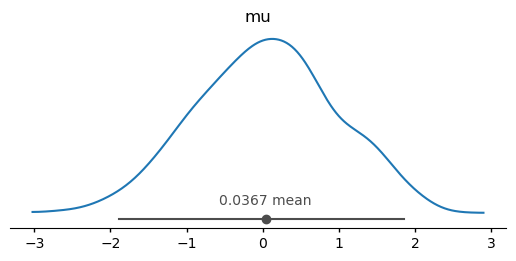

In [11]:
# arviz-stats and arviz-plots also take it into account
az.plot_dist(dt);

:::{note}
It is also possible to modify `sample_dims` through arguments to the different functions.
:::

### New data wrangling features
We have also added multiple functions to help with common data wrangling tasks,
mostly from and to `xarray.Dataset`. For example, you can convert a dataset
to a wide format dataframe with unique combinations of `sample_dims` as its rows,
with {func}`~arviz_base.dataset_to_dataframe`:

In [12]:
# back to default behaviour
az.rcParams["data.sample_dims"] = ["chain", "draw"]
dt = az.load_arviz_data("centered_eight")
az.dataset_to_dataframe(dt.posterior.dataset)

,mu,theta[Choate],theta[Deerfield],theta[Phillips Andover],theta[Phillips Exeter],theta[Hotchkiss],theta[Lawrenceville],theta[St. Paul's],theta[Mt. Hermon],tau
"(0, 0)",7.871796,12.320686,9.905367,14.951615,11.011485,5.579602,16.901795,13.198059,15.061366,4.725740
"(0, 1)",3.384554,11.285623,9.129324,3.139263,9.433211,7.811516,2.393088,10.055223,6.176724,3.908994
"(0, 2)",9.100476,5.708506,5.757932,10.944585,5.895436,9.992984,8.143327,7.604753,8.767647,4.844025
"(0, 3)",7.304293,10.037275,8.809068,9.900924,5.768832,9.062876,6.958424,10.298256,3.155304,1.856703
"(0, 4)",9.879675,9.149146,5.764986,7.015397,15.688710,3.097395,12.025763,11.316745,17.046142,4.748409
...,...,...,...,...,...,...,...,...,...,...
"(3, 495)",1.542688,3.737751,5.393632,0.487845,4.015486,0.717057,-2.675760,0.415968,-4.991247,2.786072
"(3, 496)",1.858580,-0.291737,0.110315,1.468877,-3.653346,1.844292,6.055714,4.986218,9.290380,4.281961
"(3, 497)",1.766733,3.532515,2.008901,0.510806,0.832185,2.647687,4.707249,3.073314,-2.623069,2.740607
"(3, 498)",3.486112,4.182751,7.554251,4.456034,3.300833,1.563307,1.528958,1.096098,8.452282,2.932379


Note it is also aware of ArviZ naming conventions in addition to using
the `sample_dims` `rcParam`. It can be further customized through a `labeller` argument.

:::{tip}
If you want to convert to a long format dataframe, you should use
{meth}`xarray.Dataset.to_dataframe` instead.
:::

## `arviz-stats`
Stats and diagnostics related functionality have also had some changes,
and it should also be noted that out of the 3 new modular libraries it is
currently the one lagging behind a bit more. At the same time,
it does already have several new features that won't be added to legacy ArviZ at any point,
check out its {doc}`arviz_stats:api/index` page for the complete and up to date list
of available functions.

### `dim` and `sample_dims`
Similarly to the rest of the libraries, most functions take an argument to indicate
which dimensions should be reduced (or considered core dims) in the different computations.
Given `arviz-stats` is the one with behaviour and API closest to xarray itself,
this argument can either be `dim` or `sample_dims` as a way to keep the APIs of ArviZ
and xarray similar.

The differences are more easily explained with a Dataset as input, but they are the same
for DataArray or DataTree inputs too. Here is a quick summary:

* `sample_dims` is used for computations where all input variables need to have all dimensions
  given through `sample_dims`.

  One example is `rhat` where the dimensions "chain" and "draw"
  are required to be present in all the inputs otherwise it makes no sense. Another is `ess`.
  `ess` is not so restrictive, we can still compute it over a single dimension, but
  given an input Dataset it doesn't make sense to compute `ess` over "chain" and "draw"
  dimensions for the 1st variable and only over "draw" dimension in the 2nd variable because it has
  no "chain" dimension.

  xarray only has one function with this restriction: {meth}`xarray.Dataset.to_stacked_array`,
  which is similar (and used by) the new {func}`arviz_base.dataset_to_dataarray`.
* `dim` is used for computations where the function acting over different subsets of the
  dimensions given through `dim` is perfectly valid.

  One example is `hdi` where we'll generally reduce both "chain" and "draw" dimensions,
  which will be present in all variables, but we might also want to reduce "chain", "draw" and a
  dimension representing a hierarchy. In this second case, all variables without the hierarchy
  dimension will have only "chain" and "draw" reduced and the ones having the hierarchy dimension
  will have all 3 dimensions reduced.

  Most xarray functions fall in this category: {meth}`~xarray.Dataset.mean`,
  {meth}`~xarray.Dataset.quantile`, {meth}`~xarray.Dataset.std`, {meth}`~xarray.Dataset.cumsum`...

Let's see it in action:

In [13]:
# as mentioned, this would be equivalent to not using sample_dims
# because this is the default in rcParams
az.ess(dt, sample_dims=["chain", "draw"])

<xarray.DataTree 'posterior'>
Group: /posterior
    Dimensions:  (school: 8)
    Coordinates:
      * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
    Data variables:
        mu       float64 8B 241.0
        theta    (school) float64 64B 365.0 427.3 514.7 337.2 ... 521.5 275.7 451.9
        tau      float64 8B 66.57

In [14]:
az.ess(dt, sample_dims="draw")

<xarray.DataTree 'posterior'>
Group: /posterior
    Dimensions:  (chain: 4, school: 8)
    Coordinates:
      * chain    (chain) int64 32B 0 1 2 3
      * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
    Data variables:
        mu       (chain) float64 32B 81.14 69.3 77.84 10.48
        theta    (chain, school) float64 256B 114.0 122.3 151.3 ... 87.4 56.41 38.0
        tau      (chain) float64 32B 49.97 10.58 16.32 8.934

Both these cases work because all variables have "chain"+"draw" dimension, and therefore
all variables also have the "draw" dimension. But if we attempted to add "school",
be it alone or in combination with "chain" and/or "draw" we'd get an error.
At the time of writing depending on the input the error can be quite cryptic but it will
hopefully become more informative as we continue to work on arviz-stats.

It is not an issue to add "school" to `hdi` calls:

In [15]:
# the dim argument also takes the default from rcParams when dim=None,
# consequently, this is equivalent to dt.azstats.hdi()
dt.azstats.hdi(dim=["chain", "draw"])

<xarray.DataTree 'posterior'>
Group: /posterior
    Dimensions:   (ci_bound: 2, school: 8)
    Coordinates:
      * ci_bound  (ci_bound) <U5 40B 'lower' 'upper'
      * school    (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
    Data variables:
        mu        (ci_bound) float64 16B -1.623 10.69
        theta     (school, ci_bound) float64 128B -4.564 17.13 ... -5.858 16.01
        tau       (ci_bound) float64 16B 0.8965 9.668

In [16]:
dt.azstats.hdi(dim=["chain", "draw", "school"])

<xarray.DataTree 'posterior'>
Group: /posterior
    Dimensions:   (ci_bound: 2)
    Coordinates:
      * ci_bound  (ci_bound) <U5 40B 'lower' 'upper'
    Data variables:
        mu        (ci_bound) float64 16B -1.623 10.69
        theta     (ci_bound) float64 16B -5.719 14.86
        tau       (ci_bound) float64 16B 0.8965 9.668

### Accessors on xarray objects
We are also taking advantage of the fact that xarray allows third party libraries to register
accessors on its object. This means that _after importing `arviz_stats`_ (or a library that imports
it like `arviz.preview`) DataArrays, Datasets and DataTrees get a new attribute, `azstats`.
This attribute is called accessor and exposes ArviZ functions that act on the object from which
the accessor is used.

We plan to have most functions available as both top level functions and accessors to help
with discoverability of ArviZ functions. But not all functions can be implemented as
accessors to all objects. Mainly, functions that need multiple groups can be available
on the DataTree accessor, but not on Dataset or DataArray ones. Moreover, at the time of
writing, some functions are only available as one of the two options but should be extended soon.

We have already used the `azstats` accessor to compute the HDI, now we can check that
we get the same result when using `ess` through the accessor than what we got when using
the top level function:

In [17]:
dt.azstats.ess()

<xarray.DataTree 'posterior'>
Group: /posterior
    Dimensions:  (school: 8)
    Coordinates:
      * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
    Data variables:
        mu       float64 8B 241.0
        theta    (school) float64 64B 365.0 427.3 514.7 337.2 ... 521.5 275.7 451.9
        tau      float64 8B 66.57

### Computational backends
We have also modified a bit how computations accelerated by optional dependencies are handled.
There are no longer dedicated "flag classes" like we had for Numba and Dask. Instead,
low level stats functions are implemented in classes so we can subclass and reimplement only
bottleneck computations (with the rest of the computations being inherited from the base class).

The default computational backend is controlled by `rcParams["stats.module"]` which can be
"base", "numba" or a user defined custom computational module[^2]. 

[^2]: User defined modules are valid when doing `rcParams["stats.module"] = module` but can't
    can't be set as the default through the `arvizrc` configuration file.

In [18]:
dt = az.load_arviz_data("radon")
az.rcParams["stats.module"] = "base"
%timeit dt.azstats.histogram(dim="draw")

245 ms ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
az.rcParams["stats.module"] = "numba"
%timeit dt.azstats.histogram(dim="draw")

193 ms ± 49.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
az.rcParams["stats.module"] = "base"

The histogram method is one of the re-implemented ones, mostly so it scales better to larger data.
However, it should be noted that we haven't really done much profiling nor in-depth optimization
efforts. Please open issues if you notice performance regressions or open issues/PRs to 
discuss and implement faster versions of the bottleneck methods.

### Array interface
It is also possible to install `arviz-stats` without xarray or `arviz-base` in which case,
only a subset of the functionality is available, and through an array only API.
This API has little to no defaults or assumptions baked into it, leaving all the choices
to the user who has to be explicit in every call.

Due to the dependencies
needed to install this minimal version of `arviz-stats` being only NumPy and SciPy
we hope it will be particularly useful to other developers.
PPL developers can for example use `arviz-stats` for MCMC diagnostics without having to add
xarray or pandas as dependencies of their library. This will ensure they are using
tested and up to date versions of the diagnostics without having to implement or maintain
them as part of the PPL itself.

The array interface is covered in detail at the {ref}`arviz_stats:array_interface` page.

## `arviz-plots`

Out of the 3 libraries, `arviz-plots` is the one with the most changes at all levels,
breaking changes, new features more layers to explore.

### More and better supported backends!
One of they key efforts of the refactor has been simplifying the way we interface
with the different plotting backends supported.
arviz-plots has more backends: matplotlib, bokeh and plotly are all supported now,
with (mostly) feature parity among them. All while having less backend related code!

### Plotting function inventory

The following functions have been renamed or restructured:

|   ArviZ <1       |   ArviZ >=1       |
|------------------|-------------------|
| plot_bpv                     | plot_ppc_pit, plot_ppc_tstat     |
| plot_dist_comparison         | plot_prior_posterior             |
| plot_ecdf                    | plot_dist, plot_ecdf_pit         |
| plot_ess                     | plot_ess, plot_ess_evolution     |
| plot_forest                  | plot_forest, plot_ridge          |
| plot_ppc                     | plot_ppc_dist                    |
| plot_posterior, plot_density | plot_dist                        |
| plot_trace                   | plot_trace_dist, plot_trace_rank |

Others have had their code rewritten and their arguments updated to some extent,
but kept the same name:

* plot_autocorr
* plot_compare
* plot_energy
* plot_loo_pit
* plot_mcse
* plot_rank

The following functions have been added:

* {func}`~arviz_plots.plot_convergence_dist`
* {func}`~arviz_plots.plot_pair_focus`
* {func}`~arviz_plots.plot_ppc_pava`
* {func}`~arviz_plots.plot_ppc_rootogram`
* {func}`~arviz_plots.plot_psense_dist`
* {func}`~arviz_plots.plot_psense_quantities`
* {func}`~arviz_plots.plot_trace`

Some functions have been removed and we don't plan to add them:

* plot_dist
* plot_kde

And there are also functions we plan to add but aren't available yet.

* plot_elpd
* plot_khat
* plot_pair
* plot_parallel
* plot_ppc_censored
* plot_ppc_residuals
* plot_violin
* plot_ts
* plot_lm

:::{note}
For now, the documentation for arviz-plots defaults to `latest` which is built
from GitHub with each commit. If you see some of the functions in the last block already
on the example gallery you should be able to try them, but only if you install
the development version! See {ref}`arviz_plots:installation`
:::

You can see all of them at the {ref}`arviz-plots gallery <arviz_plots:example_gallery>`.

### What to expect from the new plotting functions

There are two main differences with the plotting functions here in legacy ArviZ:

1. The way of forwarding arguments to the plotting backends.
2. The return type is now {class}`PlotCollection`, one of the key features of `arviz-plots`.
   A quick overview in the context of `plot_xyz` is given here but it later has a section of
   its own.

Other than that, some arguments have been renamed or gotten different defaults,
but nothing major. Note, however, that we have incorporated elements
from grammar of graphics into `arviz-plots`, now that we'll cover the internals
of `plot_xyz` in passing we'll use some terms from grammar of graphics.
If you have never heard about grammar of graphics we recommend you take
a look at {ref}`arviz_plots:overview_plots` before continuing.

#### kwarg forwarding
Most `plot_xyz` functions now have a `visuals` and a `stats` argument. These arguments
are dictionaries whose keys define where their values are forwarded too. The values
are also dictionaries representing keyword arguments that will be passed downstream
via `**kwargs`. This allows you to send arbitrary keyword arguments to all the different
visual elements or statistical computations that are part of a plot without
bloating the call signature with endless `xyz_kwargs` arguments like in legacy ArviZ.

These same arguments also allow indicating a visual element should not be added to the plot,
or providing pre computed statistical summaries for faster re-rendering of plots (at the time
of writing pre-computed inputs are only working in `plot_forest` but should be extended soon).

In addition, the call signature of new plotting functions is `plot_xyz(..., **pc_kwargs)`,
with these `pc_kwargs` being forwarded to the initialization of {class}`PlotCollection`.
This argument allows controlling the layout of the {term}`arviz_plots:figure` as well
as any {term}`arviz_plots:aesthetic mappings` that might be used by the plotting function.

For a complete notebook introduction on this see {ref}`arviz_plots:plots_intro`

#### New return type: `PlotCollection`
All `plot_xyz` functions now return a "plotting manager class". At the time of writing
this means either {class}`~arviz_plots.PlotCollection` (vast majority of plots) or
{class}`PlotMatrix` (for upcoming `plot_pair` for example).

These classes are the ones that handle {term}`arviz_plots:faceting` and
{term}`arviz_plots:aesthetic mappings` and allow the `plot_xyz` functions to
focus on the {term}`arviz_plots:visuals` and not on the plot layout or encodings.

See {ref}`arviz_plots:use_plotcollection` for more details on how to work with
existing `PlotCollection` instances.

### Plotting manager classes
As we have just mentioned, `plot_xyz` use these plotting manager classes and then return them
as their output. In addition, we hope users will use these classes directly to help them
write custom plotting functions more easily and with more flexibility.

By using these classes, users should be able to focus on writing smaller functions that take
care of a "unit of plotting". You can then use their `.map` methods to apply these plotting
functions as many times as needed given the faceting and aesthetic mappings defined by the user.
Different layouts and different mappings will generally not require changes to these plotting
functions, only to the arguments that define aesthetic mappings and the faceting strategy.

Take a look at {ref}`arviz_plots:compose_own_plot` if that sounds interesting!

### Other arviz-plots features
There are also helper functions to help compose or extend existing plotting functions.
For example, we can create a new plot, with a similar layout to that of `plot_trace_dist`
or `plot_rank_dist` but custom diagnostics in each column: distribution, rank and ess evolution:

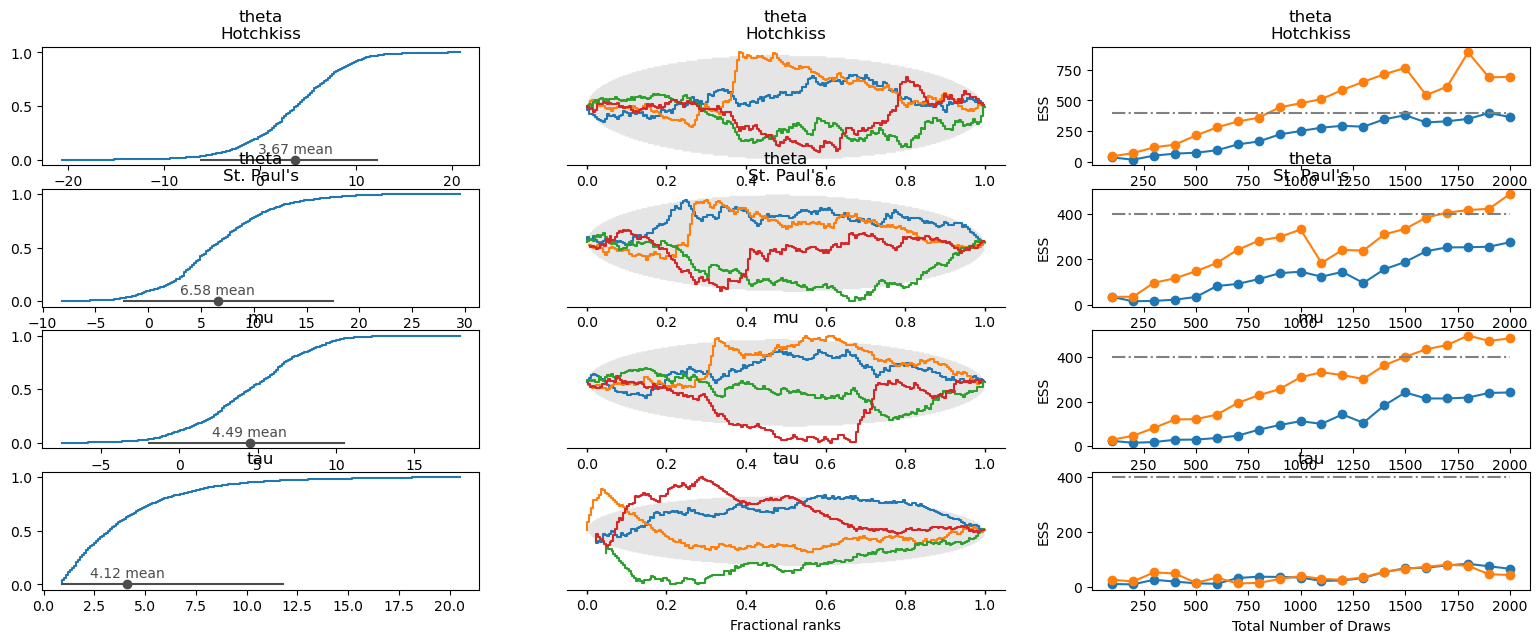

In [21]:
dt = az.load_arviz_data("centered_eight")
az.combine_plots(
    dt,
    [
        (az.plot_dist, {"kind": "ecdf"}),
        (az.plot_rank, {}),
        (az.plot_ess_evolution, {}),
    ],
    var_names=["theta", "mu", "tau"],
    coords={"school": ["Hotchkiss", "St. Paul's"]},
)